In [1]:
# Obtain GPU detals

!nvidia-smi

Mon Dec  9 04:54:38 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# Obtain CUDA version and other details

!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [3]:
# Install Tensorflow 2.0 GPU version

!pip install tensorflow-gpu

     |████████████████████████████████| 380.8MB 46kB/s 
     |████████████████████████████████| 450kB 53.7MB/s 
     |████████████████████████████████| 3.8MB 54.6MB/s 
     |████████████████████████████████| 81kB 13.5MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.2 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled goog

In [0]:
# Install imageio to generate GIFs
!pip install -q imageio

In [1]:
# Import all the necessary libraties i.e. numpy, PIL, os, tensorflow
# Print tensorflow and tf.keras versions

import numpy as np
import glob
import imageio
import os
import PIL
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import time

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, ZeroPadding2D, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.losses import binary_crossentropy
from IPython import display

print(tf.version.VERSION)
print(tf.keras.__version__)

2.0.0
2.2.4-tf


In [0]:
# Enable eager execution in tensorflow. This is to ensure we use custom training loop with Gradient tape

#tf.compat.v1.disable_eager_execution()
tf.compat.v1.enable_eager_execution()

In [3]:
# !unzip data.zip

Archive:  data.zip
   creating: data/IndianCars/
  inflating: data/IndianCars/images.jpg  
  inflating: data/IndianCars/images_002.jpg  
  inflating: data/IndianCars/images_002_800 (1).jpg  
  inflating: data/IndianCars/images_002_800 (10).jpg  
  inflating: data/IndianCars/images_002_800 (11).jpg  
  inflating: data/IndianCars/images_002_800 (12).jpg  
  inflating: data/IndianCars/images_002_800 (13).jpg  
  inflating: data/IndianCars/images_002_800 (14).jpg  
  inflating: data/IndianCars/images_002_800 (15).jpg  
  inflating: data/IndianCars/images_002_800 (16).jpg  
  inflating: data/IndianCars/images_002_800 (17).jpg  
  inflating: data/IndianCars/images_002_800 (18).jpg  
  inflating: data/IndianCars/images_002_800 (19).jpg  
  inflating: data/IndianCars/images_002_800 (2).jpg  
  inflating: data/IndianCars/images_002_800 (20).jpg  
  inflating: data/IndianCars/images_002_800 (21).jpg  
  inflating: data/IndianCars/images_002_800 (22).jpg  
  inflating: data/IndianCars/images_002_

In [0]:
# !mkdir data2

# import os
# import cv2
# for i in os.listdir('data/IndianCars'):
#   im = cv2.imread('data/IndianCars/'+i)
#   im = cv2.resize(im, (96, 96))
#   cv2.imwrite('data2/'+i, im)

In [3]:
data_root = "drive/My Drive/data2"
# Attach google drive to colab notebook

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# Image dimensions are set to 96x96. The decode_img function returns a image tensor with float values. Source : https://www.tensorflow.org/tutorials/load_data/images by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License") 

IMG_WIDTH = 96
IMG_HEIGHT = 96

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
# Function that returns an image tensor by reading the image from the given file_path argument. Source : https://www.tensorflow.org/tutorials/load_data/images by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License") 

def process_path(file_path):
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

In [0]:
# list_ds stores the list of files i.e. jpeg files of car images

list_ds = tf.data.Dataset.list_files(data_root+'/'+'*')

In [0]:
# Setup AUTOTUNE and use map to process mutliple images. Source : https://www.tensorflow.org/tutorials/load_data/images by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License") 

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
Image_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [8]:
# Print the shape of the image

for image in Image_ds.take(1):
  print("Image shape: ", image.numpy().shape)

Image shape:  (96, 96, 3)


In [0]:
# Function to generate a dataset using shuffle, batch and prefect operations from tf.records, tf.data. Source : https://www.tensorflow.org/tutorials/load_data/images by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License") 

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  #ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
# Set batch size and then preprate a dataset for training

BATCH_SIZE = 128

train_ds = prepare_for_training(Image_ds)

In [0]:
# Function that defines a generator model. This is basically a DEConvolution network.  Modified from Source : https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License") 


def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(6*6*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((6, 6, 256)))
    assert model.output_shape == (None, 6, 6, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 6, 6, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 12, 12, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())



    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 12, 12, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 12, 12, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 24, 24, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())



    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 24, 24, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 24, 24, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 48, 48, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


 
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 48, 48, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 48, 48, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 96, 96, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 96, 96, 3)

    return model

In [0]:
# Function that defines a discriminator model. This is basically a Convolutional Neural Network (CNN), which classifies fake vs real i.e. binary classification. Modified from Source : https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License")

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[96, 96, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))


    model.add(layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))


    model.add(layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))


    model.add(layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [0]:
# f = open('/content/drive/My Drive/GAN_Models/checkpoint', 'w')
# f.write('model_checkpoint_path: "DCGANckpt-135"')
# f.write('all_model_checkpoint_paths: "DCGANckpt-135"')
# f.close()

In [14]:
# Create a generator model and check the model summary for shape information.

model = make_generator_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9216)              921600    
_________________________________________________________________
batch_normalization (BatchNo (None, 9216)              36864     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 9216)              0         
_________________________________________________________________
reshape (Reshape)            (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 6, 6, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 6, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6, 6, 128)         0

In [15]:
# Create a discriminator model and check the model summary for shape information.

model = make_discriminator_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        4864      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 128)       204928    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 48, 48, 128)       0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 48, 48, 128)      

(1, 100)
(96, 96, 3)
tf.Tensor(
[[[ 9.16209865e-06  2.53767175e-05 -1.51762629e-06]
  [ 1.16287924e-06 -5.42956650e-06  3.57633253e-05]
  [ 9.61040678e-06  1.99909027e-05  5.95580605e-06]
  ...
  [-5.87355717e-05 -9.18943624e-06  2.20757147e-06]
  [ 3.54385265e-05 -3.92261063e-06 -2.11638217e-05]
  [-1.27937938e-05  1.71085867e-06 -2.27463206e-05]]

 [[ 1.50254082e-05  8.42649752e-06 -2.69960601e-05]
  [-2.16750104e-05  4.54649198e-05  8.93179458e-06]
  [ 2.94948268e-06  1.36289118e-05 -1.02227295e-06]
  ...
  [ 2.34905183e-05 -4.21666045e-05  6.55326439e-05]
  [-7.32296667e-06 -4.88090445e-05 -1.09727662e-05]
  [-2.53651215e-05 -7.51659263e-06 -1.81981086e-05]]

 [[-2.85156366e-05  8.38953201e-06  6.05643436e-06]
  [ 3.78784280e-05  2.98391860e-05 -2.33228257e-05]
  [ 2.97632323e-05  3.32046397e-06  2.05581364e-05]
  ...
  [-4.63986689e-05 -4.32240267e-05 -3.13934870e-05]
  [ 1.29698628e-06 -8.02247596e-05  2.86979575e-05]
  [-1.95117500e-05  1.97753388e-06 -5.29982608e-05]]

 ...

 [

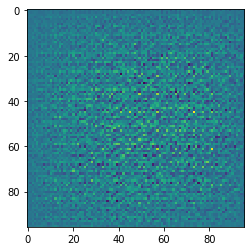

In [16]:
# Pass random noise as input to the generator and visualize the output from the generator. Adopted from Source : https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License")

import matplotlib.cm as cm
generator = make_generator_model()

noise = tf.random.normal([1, 100])
print(noise.shape)
generated_image = generator(noise, training=False)
print(generated_image[0, :, :, :].shape)
print(generated_image[0, :, :, :])
img = tf.image.convert_image_dtype(generated_image[0, :, :, :], tf.uint8)
print(img)
plt.imshow(generated_image[0, :, :, 0])

In [17]:
# Print the output from the discriminator after passing the generated output from the previous step. Source : https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License")

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-2.0152781e-06]], shape=(1, 1), dtype=float32)


In [0]:
# This method returns a helper function to compute cross entropy loss. Source : https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License")
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
# Function to define discriminator loss. Source : https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License")


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
# Function to define generator loss . Source : https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License")

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
# Define optimizer for generator and descriminator.

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [0]:
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 2

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Define check points.

checkpoint_dir = '/content/drive/My Drive/GAN_Models/'
checkpoint_prefix = os.path.join(checkpoint_dir, "DCGANckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
ckeckpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep = 3)

In [0]:
# Define training step function . Source : https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License")

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [0]:
# Define function for training . Source : https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License")

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go for every 50 epochs
    if (epoch + 1) % 25 == 0:
      display.clear_output(wait=True)
      generate_and_save_images(generator,
                             epoch + 1,
                             seed, save=False)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed, save=True)

In [0]:
# Function to generate and save images. Modified from Source : https://www.tensorflow.org/tutorials/generative/dcgan by The Tensorflow Authors Licensed under the Apache License, Version 2.0 (the "License")


def generate_and_save_images(model, epoch, test_input, save = False):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8,8), dpi = 200)

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      img = tf.image.convert_image_dtype(predictions[i, :, :, :], tf.uint8)
      #img = tf.io.encode_j peg(img)
      #display_img = plt.imread(img)
      plt.imshow(img, cmap = None )
      plt.axis('off')
  
  if save == True:
    plt.savefig('image_at_epoch_{:04d}.jpg'.format(epoch))
  plt.show()

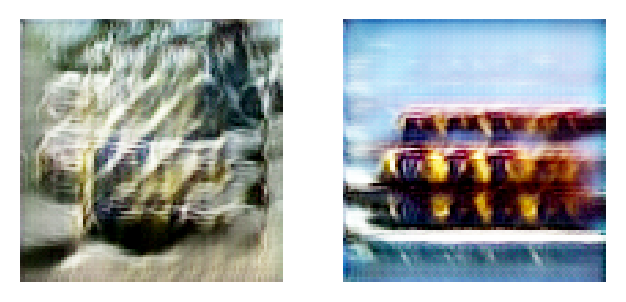

In [30]:
# Train for 1000 epochs (epoch 1 to epoch 1000)
#train(train_ds, 3)
train(train_ds, 4000)

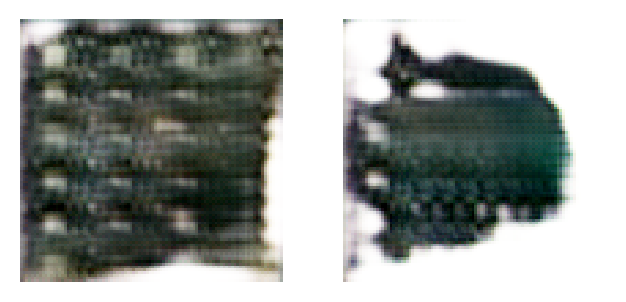

In [0]:
train(train_ds, 100)

In [0]:
# Restore the checkpoint as the training was terminated due to network issues and colab restart

status = checkpoint.restore(tf.train.latest_checkpoint('/content/drive/My Drive/GAN_Models/'))
#print(tf.train.CheckpointManager.checkpoints)
#tf.train.checkpoints_iterator()
#status.assert_existing_objects_matched()

ERROR:tensorflow:Couldn't match files for checkpoint /content/drive/My Drive/GAN_Models/DCGANckpt-135


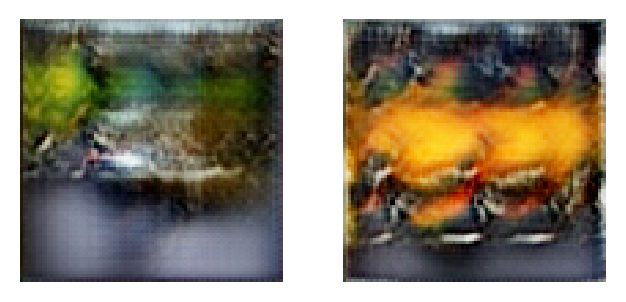

In [0]:
train(train_ds, EPOCHS)

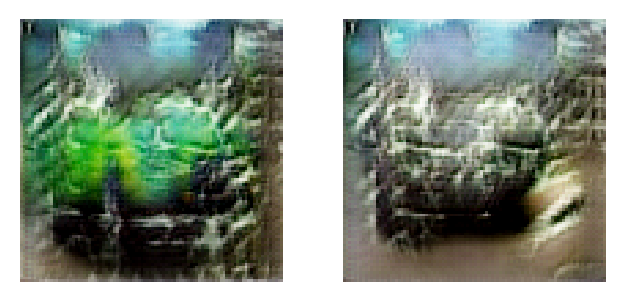

In [0]:
train(train_ds, EPOCHS)

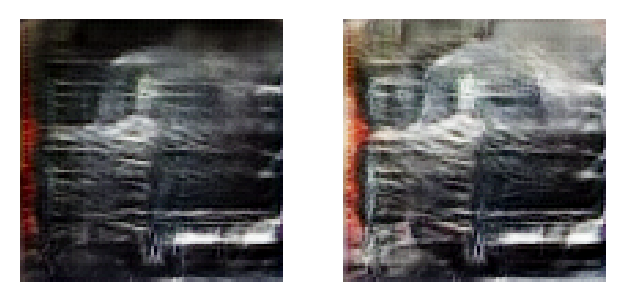

In [0]:
train(train_ds, EPOCHS)

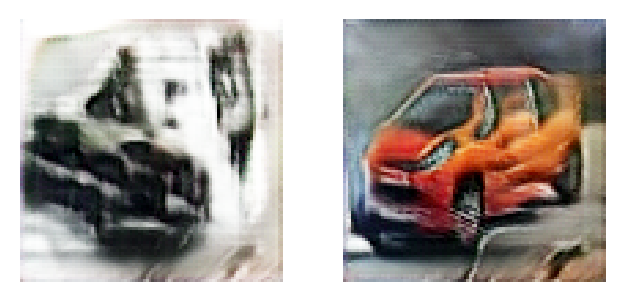

In [0]:
train(train_ds, EPOCHS)

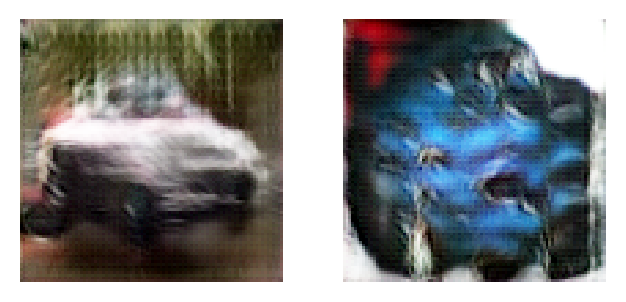

In [45]:
train(train_ds, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


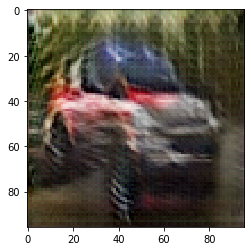

In [46]:
import matplotlib.cm as cm

noise = tf.random.normal([400, 100])
generated_image = generator(noise, training=False)
img = tf.image.convert_image_dtype(generated_image[0, :, :, :], tf.uint8)
plt.imshow(generated_image[0, :, :, :])